# Adjoint inverse design of a quantum emitter light extractor

> The cost of running the entire optimization is about 8 FlexCredit (check this)

In this tutorial, we will show how to perform the adjoint-based inverse design of a quantum emitter (QE) light extraction structure. We will use a `PointDipole` to model the QE embedded within an integrated dielectric waveguide. Then, we will build an optimization problem to maximize the extraction efficiency of the dipole radiation into a collection waveguide. In addition, we will show how to use `FieldMonitor` objects in adjoint simulations to calculate the flux radiated from the dipole. You can also find helpful information in this related [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/).

<img src="img/adjoint_12.png" width=400 alt="Schematic of the light extractor">

If you are unfamiliar with inverse design, we recommend the [inverse design lectures](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and this [introductory tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Quickstart/).

Let's start by importing the Python libraries used throughout this notebook.

In [1]:
# Standard python imports.
from typing import List
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import optax
import pickle

# Import autograd for automatic differentiation.
import autograd as ag
import autograd.numpy as anp
from tidy3d.plugins.autograd import rescale, make_filter_and_project, make_erosion_dilation_penalty, value_and_grad

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

## Simulation Set Up
The coupling region (design region) extends a single-mode dielectric waveguide placed over a lower refractive index substrate. The QE is modeled as a `PointDipole` oriented in the `y`-direction. The QE is placed within the design region so we surround it with a constant refractive index region to protect it from etching.

In [2]:
# Geometric parameters.
cr_w = 1.0  # Coupling region width (um).
cr_l = 3.0  # Coupling region length (um).
wg_thick = 0.19  # Collection waveguide thickness (um).
wg_width = 0.35  # Collection waveguide width (um).
wg_length = 1.0  # Collection waveguide length (um).

# Material.
n_wg = 3.50  # Structure refractive index.
n_sub = 1.44  # Substrate refractive index.

# Fabrication constraints.
min_feature = 0.06  # Minimum feature size.
non_etch_r = 0.06  # Non-etched circular region radius (um).

# Inverse design set up parameters.
grid_size = 0.015  # Simulation grid size on design region (um).
max_iter = 100  # Maximum number of iterations.
iter_steps = 5  # Beta is increased at each iter_steps.
beta_min = 1.0  # Minimum value for the tanh projection parameter.
learning_rate = 0.02

# Simulation wavelength.
wl = 0.94  # Central simulation wavelength (um).
bw = 0.04  # Simulation bandwidth (um).
n_wl = 41  # Number of wavelength points within the bandwidth.

Let's calculate some variables used throughout the notebook. Here, we will also define the QE position and monitor planes.

In [3]:
# Minimum and maximum values of the permittivity.
eps_max = n_wg**2
eps_min = 1.0

# Material definition.
mat_wg = td.Medium(permittivity=eps_max)
mat_sub = td.Medium(permittivity=n_sub**2)

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 3e-12

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = wg_length + cr_l + pml_spacing
size_y = cr_w + 2 * pml_spacing
size_z = wg_thick + 2 * pml_spacing
eff_inf = 10

# Source position and monitor planes.
cr_center_x = wg_length + cr_l / 2
qe_pos = td.Box(center=(cr_center_x - 0.5, 0, 0), size=(0, 0, 0))
qe_field_plan = td.Box.surfaces(center=(cr_center_x, 0, 0), size=(cr_l, cr_w, 2 * wg_thick))
wg_mode_plan = td.Box(center=(wl / 4, 0, 0), size=(0, 4 * wg_width, 5 * wg_thick))

# Number of points on design grid.
nx_grid = int(cr_l / grid_size)
ny_grid = int(cr_w / grid_size / 2)

# xy coordinates of design grid.
x_grid = np.linspace(cr_center_x - cr_l / 2, cr_center_x + cr_l / 2, nx_grid)
y_grid = np.linspace(0, cr_w / 2, ny_grid)

## Optimization Set Up
We will start defining the density-based optimization functions to transform the design parameters into permittivity values. Here we include the `ConicFilter`, where we impose a minimum feature size fabrication constraint, and the tangent hyperbolic projection function, eliminating intermediary permittivity values as we increase the projection parameter `beta`. You can find more information in the [Inverse design optimization of a compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).

In [4]:
def pre_process(params, beta):
    filter_project = make_filter_and_project(radius=min_feature, dl=grid_size, beta=beta, eta=0.5, filter_type='conic')
    params1 = filter_project(params, beta)
    return params1

def get_eps(params, beta: float = 1.00):
    """Returns the permittivities after filter and projection transformations"""
    params1 = pre_process(params, beta=beta)
    eps = eps_min + (eps_max - eps_min) * params1
    eps = anp.maximum(eps, eps_min)
    eps = anp.minimum(eps, eps_max)
    return eps

This function includes a circular region of constant permittivity value surrounding the QE. The objective here is to protect the QE from etching. In applications such as single photon sources, a larger unperturbed region surrounding the QE can be helpful to reduce linewidth broadening, as stated in `J. Liu, K. Konthasinghe, M. Davanco, J. Lawall, V. Anant, V. Verma, R. Mirin, S. Nam, S. Woo, D. Jin, B. Ma, Z. Chen, H. Ni, Z. Niu, K. Srinivasan, "Single Self-Assembled InAs/GaAs Quantum Dots in Photonic Nanostructures: The Role of Nanofabrication," Phys. Rev. Appl. 9(6), 064019 (2018)` [DOI: 10.1103/PhysRevApplied.9.064019](https://link.aps.org/doi/10.1103/PhysRevApplied.9.064019).

In [5]:
def include_constant_regions(eps, circ_center=[0, 0], circ_radius=1.0):
    # Build the geometric mask.
    yv, xv = anp.meshgrid(y_grid, x_grid)

    # Shouldn't this be --> |x-x0|^2 + |y-y0|^2 <= r*2
    geo_mask = anp.where(
        anp.abs((xv - circ_center[0]) ** 2 + (yv - circ_center[1]) ** 2) <= (circ_radius ** 2),
        1,
        0,
    ) * eps_max
    eps = anp.maximum(geo_mask, eps)
    return eps

Now, we define a function to update the `td.CustomMedium` using the permittivity distribution. The simulation will include mirror symmetry concerning the `y`-direction, so only the upper half of the design region is returned by this function during the optimization process. To get the whole structure, you need to set `unfold=True`.

In [6]:
def update_design(eps, unfold=False) -> List[td.Structure]:
    # Definition of the coordinates x,y along the design region.
    coords_x = [(cr_center_x - cr_l / 2) + ix * grid_size for ix in range(nx_grid)]
    eps_val = anp.array(eps).reshape((nx_grid, ny_grid, 1))

    if unfold == False:
        coords_yp = [0 + iy * grid_size for iy in range(ny_grid)]
        coords = dict(x=coords_x, y=coords_yp, z=[0])
        eps1 = td.SpatialDataArray(eps_val, coords)
        eps_medium = td.CustomMedium(permittivity=eps1)
        box = td.Box(center=(cr_center_x, cr_w / 4, 0), size=(cr_l, cr_w / 2, wg_thick))
        structure = [td.Structure(geometry=box, medium=eps_medium)]

    # VJP for one of anp.copy(), anp.concatenate(), or anp.fliplr() not defined,
    # so the optimization should only be run with `unfold=False` for now
    else:
        coords_y = [-cr_w / 2 + iy * grid_size for iy in range(2*ny_grid)]
        coords = dict(x=coords_x, y=coords_y, z=[0])
        eps1 = td.SpatialDataArray(anp.concatenate((anp.fliplr(anp.copy(eps_val)), eps_val), axis=1), coords)
        eps_medium = td.CustomMedium(permittivity=eps1)
        box = td.Box(center=(cr_center_x, 0, 0), size=(cr_l, cr_w, wg_thick))
        structure = [td.Structure(geometry=box, medium=eps_medium)]
    return structure

In the next cell, we define the output waveguide and the substrate, as well as the simulation monitors. It is worth mentioning the inclusion of a `ModeMonitor` in the output waveguide and a `FieldMonitor` box surrounding the dipole source to calculate the total radiated power.

In [7]:
# Input/output waveguide.
waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -wg_width / 2, -wg_thick / 2),
        rmax=(wg_length, wg_width / 2, wg_thick / 2),
    ),
    medium=mat_wg,
)

# Substrate layer.
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, -wg_thick / 2)
    ),
    medium=mat_sub,
)

# Point dipole source located at the center of TiO2 thin film.
dp_source = td.PointDipole(
    center=qe_pos.center,
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    polarization="Ey",
)

# Mode monitor to compute the FOM.
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_monitor_fom = td.ModeMonitor(
    center=wg_mode_plan.center,
    size=wg_mode_plan.size,
    freqs=[freq],
    mode_spec=mode_spec,
    name="mode_monitor_fom",
)

# Field monitor to compute the FOM.
field_monitor_fom = []
for i, plane in enumerate(qe_field_plan):
    field_monitor_fom.append(
        td.FieldMonitor(
            center=plane.center,
            size=plane.size,
            freqs=[freq],
            name=f"field_monitor_fom_{i}",
        )
    )

# Mode monitor to compute spectral response.
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_monitor = td.ModeMonitor(
    center=wg_mode_plan.center,
    size=wg_mode_plan.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_monitor",
)

# Field monitor to compute spectral response.
field_monitor = []
for i, plane in enumerate(qe_field_plan):
    field_monitor.append(
        td.FieldMonitor(
            center=plane.center, size=plane.size, freqs=freqs, name=f"field_monitor_{i}"
        )
    )

# Field monitor to visualize the fields.
field_monitor_xy = td.FieldMonitor(
    center=(size_x / 2, 0, 0),
    size=(size_x, size_y, 0),
    freqs=freqs,
    name="field_xy",
)

Lastly, we have a function that receives the design parameters from the optimization algorithm and then gathers the simulation objects altogether to create a `td.Simulation`.

In [8]:
def make_adjoint_sim(param, beta: float = 1.00, unfold=False):
    eps = get_eps(param, beta)
    eps = include_constant_regions(
        eps, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r
    )
    structure = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(center=(cr_center_x, 0, 0), size=(cr_w, cr_l, wg_thick)),
        dl=[grid_size, grid_size, grid_size],
        enforce=True)

    grid_spec=td.GridSpec.auto(
                wavelength=wl_max,
                min_steps_per_wvl=15,
                override_structures=[adjoint_dr_mesh],
            )


    return td.Simulation(
        size=[size_x, size_y, size_z],
        center=[size_x / 2, 0, 0],
        grid_spec=grid_spec,
        symmetry=(0, -1, 0),
        structures=[substrate, waveguide] + structure,
        sources=[dp_source],
        monitors=[field_monitor_xy, mode_monitor_fom] + field_monitor_fom,
        run_time=run_time,
        subpixel=True,
    )

## Initial Light Extractor Structure
Let's create a uniform initial permittivity distribution and verify if all the simulation objects are in the correct places.

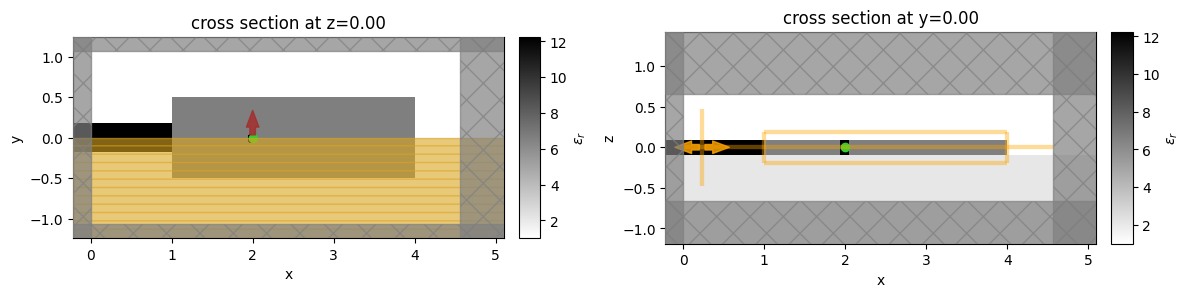

In [9]:
init_par = np.ones((nx_grid, ny_grid))*0.5
init_design = make_adjoint_sim(init_par, beta=beta_min, unfold=True)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))
init_design.plot_eps(z=0, ax=ax1, monitor_alpha=0.0)
init_design.plot_eps(y=0, ax=ax2)
plt.show()

We will also look at the collection waveguide mode to ensure we have considered the correct one in the `ModeMonitor` setup. We use the `ModeSolver` plugin to calculate the first two waveguide modes, as below.

In [10]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

sim_init = init_design.updated_copy(
    monitors=[field_monitor_xy, mode_monitor] + field_monitor
)

mode_solver = ModeSolver(
    simulation=sim_init,
    plane=wg_mode_plan,
    mode_spec=td.ModeSpec(num_modes=2),
    freqs=[freq],
)
modes = run_mode_solver(mode_solver, reduce_simulation=True)

07:00:50 EDT Mode solver created with                                           
             task_id='fdve-0aebf3c2-3796-4afe-ac71-9841c3a8d595',               
             solver_id='mo-05fa1049-d0cb-4015-aec0-789006ce2270'.

Output()

Output()

07:00:52 EDT Mode solver status: success

Output()

After inspecting the mode field distribution, we can confirm that the fundamental waveguide mode is mainly oriented in the `y`-direction, thus matching the dipole orientation.

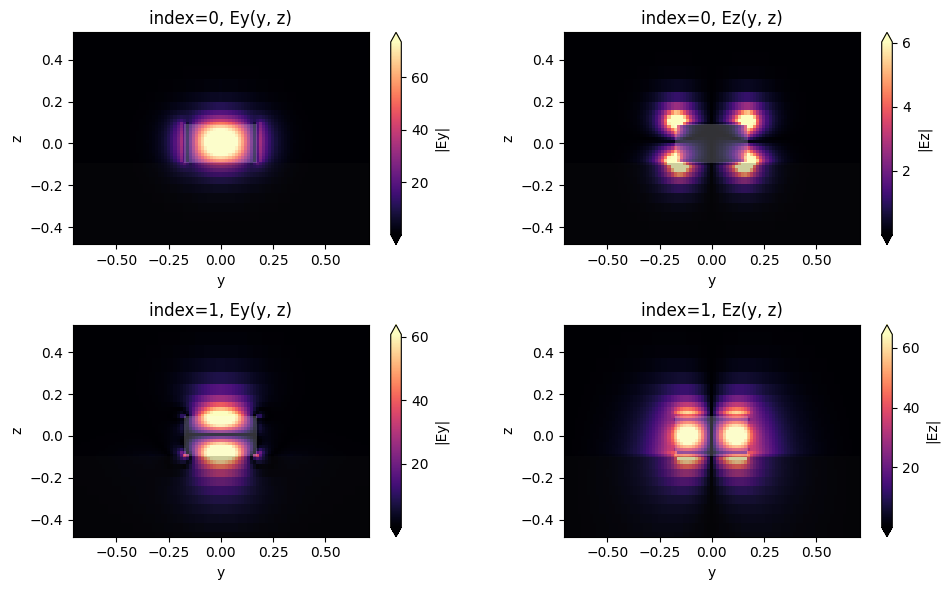

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
for mode_ind in range(2):
    for field_ind, field_name in enumerate(("Ey", "Ez")):
        ax = axs[mode_ind, field_ind]
        mode_solver.plot_field(field_name, "abs", mode_index=mode_ind, f=freq, ax=ax)
        ax.set_title(f"index={mode_ind}, {field_name}(y, z)")

Then, we will calculate the initial coupling efficiency to see how this random structure performs.

In [12]:
sim_data = web.run(sim_init, task_name="initial QE light extractor (Autograd)")

07:00:55 EDT Created task 'initial QE light extractor (Autograd)' with task_id  
             'fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=957409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=335962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1\taskId]8;;\]8;id=957409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1\=]8;;\]8;id=436377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1\fdve]8;;\]8;id=957409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1\-e5bba5a0-c31]8;;\
             ]8;id=957409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5bba5a0-c318-4f3f-a27a-cbef00ab53b1\8-4f3f-a27a-cbef00ab53b1']8;;\.

Output()

07:00:57 EDT status = success

Output()

07:01:08 EDT loading simulation from simulation_data.hdf5

The modal coupling efficiency is normalized by the dipole power. That is necessary because the dipole power will likely change significantly when the optimization algorithm modifies the design region.

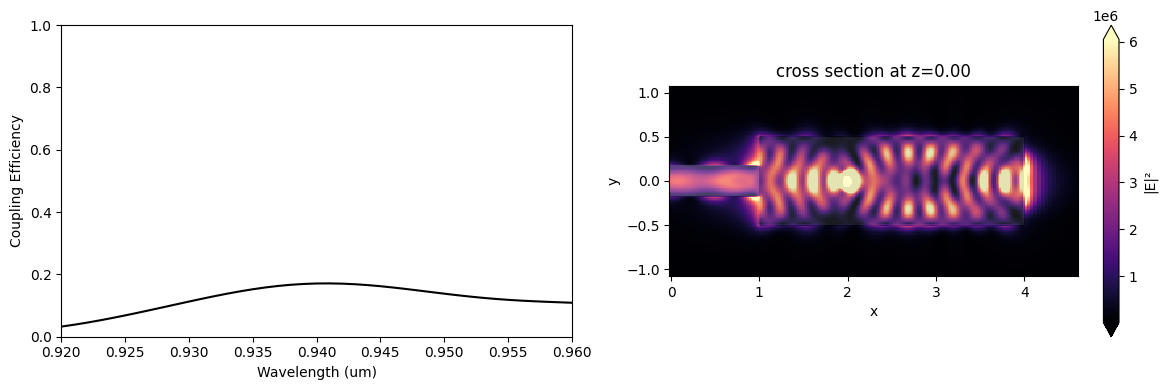

In [13]:
mode_amps = sim_data["mode_monitor"].amps.sel(direction="-", mode_index=0)
mode_power = np.abs(mode_amps) ** 2
dip_power = np.zeros(n_wl)
for i in range(len(field_monitor)):
    field_mon = sim_data[f"field_monitor_{i}"]
    dip_power += np.abs(field_mon.flux)

coup_eff = mode_power / dip_power

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_ylim(0, 1)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
sim_data.plot_field("field_xy", "E", "abs^2", z=0, ax=ax2, f=freq)
plt.show()

## Optimization
The objective function defined next is the device figure-of-merit (FOM) minus a fabrication penalty.

In [14]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: td.SimulationData) -> float:
    """Return the coupling efficiency."""
    # best to use autograd-wrapped numpy functions for differentiation
    mode_amps = sim_data['mode_monitor_fom'].amps.sel(direction="-", f=freq, mode_index=0).data
    mode_power = anp.sum(anp.abs(mode_amps) ** 2)   

    # unlike Jax version, should avoid in-place operators (e.g, `+=`), use numpy when possible
    field_mon_list = [sim_data[f'field_monitor_fom_{i}'] for i in range(0,6)]
    dip_power = anp.sum([anp.abs(mon.flux.data) for mon in field_mon_list])

    return mode_power, dip_power

def penalty(params, beta) -> float:
    """Penalize changes in structure after erosion and dilation to enforce larger feature sizes."""
    params_processed = pre_process(params, beta=beta)
    erode_dilate_penalty = make_erosion_dilation_penalty(radius=min_feature, dl=grid_size)
    ed_penalty = erode_dilate_penalty(params_processed)
    return ed_penalty

# Objective function to be passed to the optimization algorithm.
def obj(param, beta: float = 1.0, step_num: int = None, verbose: bool = False) -> float:
    sim = make_adjoint_sim(param, beta, unfold=False)   # non-differentiable if `unfold=True`
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = web.run(sim, task_name=task_name, verbose=verbose)
    mode_power, dip_power = fom(sim_data)
    fom_val = mode_power / dip_power
    penalty_weight = 0.1
    penalty_val = penalty(param, beta)
    J = fom_val - penalty_weight * penalty_val
    return J, [sim_data, mode_power, dip_power, penalty_val]

# Function to calculate the objective function value and its gradient with respect to the design parameters.
# Use tidy3d's wrapped ag.value_and_grad() for it's auxiliary data functionality
obj_grad = value_and_grad(obj, has_aux=True)

In the following cell, we define some functions to save the optimization progress and load a previous optimization from the file.

In [15]:
# where to store history
history_fname = "misc/qe_light_coupler_autograd.pkl"

def save_history(history_dict: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, "wb") as file:
        pickle.dump(history_dict, file)

def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, "rb") as file:
        history_dict = pickle.load(file)
    return history_dict

Then, we will start a new optimization or load the parameters of a previous one.

In [16]:
# initialize adam optimizer with starting parameters
optimizer = optax.adam(learning_rate=learning_rate)

try:
    history_dict = load_history()
    opt_state = history_dict["opt_states"][-1]
    params = history_dict["params"][-1]
    opt_state = optimizer.init(params)    
    num_iters_completed = len(history_dict["params"])
    print("Loaded optimization checkpoint from file.")
    print(
        f"Found {num_iters_completed} iterations previously completed out of {max_iter} total."
    )
    if num_iters_completed < max_iter:
        print(f"Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except FileNotFoundError:
    params = anp.array(init_par)
    opt_state = optimizer.init(params)
    history_dict = dict(
        values=[],
        coupl_eff=[],
        penalty=[],
        params=[],
        gradients=[],
        opt_states=[opt_state],
        data=[],
        beta=[],
    )

Loaded optimization checkpoint from file.
Found 100 iterations previously completed out of 100 total.
Optimization completed, will return results.


In the optimization loop, we will gradually increase the projection parameter `beta` to eliminate intermediary permittivity values. At each iteration, we record the design parameters and the optimization history to restore them as needed.

In [17]:
iter_done = len(history_dict["values"])
if iter_done < max_iter:
    # small # of iters for quick testing
    for i in range(iter_done, max_iter):
        print(f"Iteration = ({i + 1} / {max_iter})")
        plt.subplots(1,1, figsize=(3,2))
        plt.imshow(np.flipud(1-params.T), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

        # Compute gradient and current objective function value.
        beta_i = i//iter_steps + beta_min
        (value, gradient), data = obj_grad(params, beta=beta_i, step_num=(i + 1))
        sim_data_i, mode_power_i, dip_power_i, penalty_val_i = [data[0]]+[dat._value for dat in data[1:]]
        # Outputs.
        print(f"\tbeta = {beta_i}")
        print(f"\tJ = {value:.4e}")
        print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")
        print(f"\tpenalty = {penalty_val_i:.3f}")
        print(f"\tmode power = {mode_power_i:.3f}")
        print(f"\tdip power = {dip_power_i:.3f}")
        print(f"\tcoupling efficiency = {mode_power_i/dip_power_i:.3f}")

        # Compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn).
        updates, opt_state = optimizer.update(-gradient, opt_state, params)
        params = optax.apply_updates(params, updates)

        # Cap parameters between 0 and 1.
        params = anp.minimum(params, 1.0)
        params = anp.maximum(params, 0.0)

        # Save history.
        history_dict["values"].append(value)
        history_dict["coupl_eff"].append(mode_power_i / dip_power_i)
        history_dict["penalty"].append(penalty_val_i)
        history_dict["params"].append(params)
        history_dict["beta"].append(beta_i)
        history_dict["gradients"].append(gradient)
        history_dict["opt_states"].append(opt_state)
        #history_dict["data"].append(sim_data_i)  # Uncomment to store data, can create large files.
        save_history(history_dict)

Ultimately, we get all the information to assess the optimization results.

In [18]:
obj_vals = np.array(history_dict["values"])
ce_vals = np.array(history_dict["coupl_eff"])
pen_vals = np.array(history_dict["penalty"])
final_par_density = history_dict["params"][-1]
final_beta = history_dict["beta"][-1]

In [19]:
# just to inspect design at different iterations
def unfold_params(params):
    params = np.concatenate((np.fliplr(np.copy(params)), params), axis=1)
    return params

params1 = history_dict['params'][32]
params1_full = pre_process(params1, beta=final_beta)
params1_full = include_constant_regions(
        params1_full, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r)
params1_full = unfold_params(params1_full)

params2 = history_dict['params'][-1]
params2_full = pre_process(params2, beta=final_beta)
params2_full = include_constant_regions(
        params2_full, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r)
params2_full = unfold_params(params2_full)

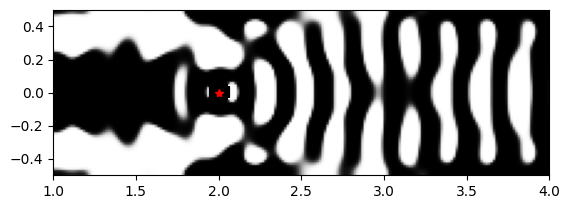

In [20]:
plt.imshow(1-np.flipud(params1_full.T), cmap='gray', vmin=0, vmax=1, extent=[wg_length, cr_l+wg_length, -cr_w/2, cr_w/2])
plt.plot(dp_source.center[0], 0, 'r*')
plt.show()

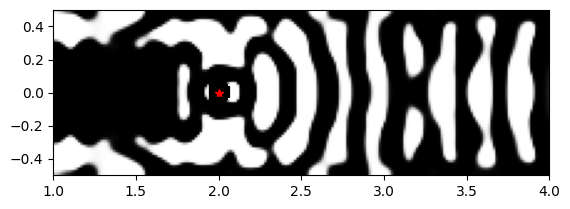

In [21]:
plt.imshow(1-np.flipud(params2_full.T), cmap='gray', vmin=0, vmax=1, extent=[wg_length, cr_l+wg_length, -cr_w/2, cr_w/2])
plt.plot(dp_source.center[0], 0, 'r*')
plt.show()

### Results
The following figure shows how coupling efficiency and the fabrication penalty have evolved along the optimization process. The coupling efficiency quickly rises above 0.8, and along the binarization process, we can observe two large drops before a more stable final optimization stage. The formation of resonant modes sensitive to the small structural changes can potentially explain this behavior. The discontinuities in the fabrication penalty curve are caused by the increments in the projection parameter beta at each 5 iterations.

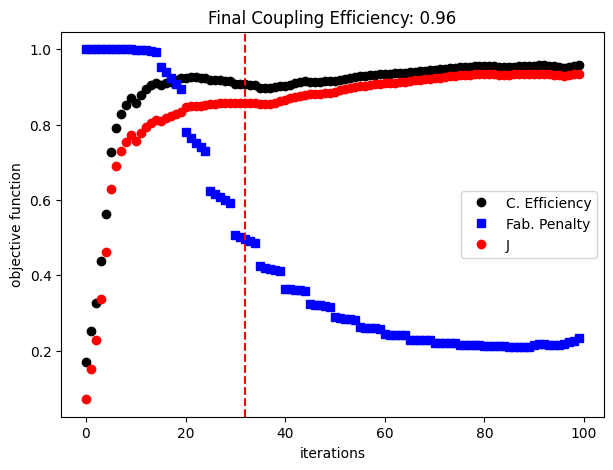

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(ce_vals, "ko", label="C. Efficiency")
ax.plot(pen_vals, "bs", label="Fab. Penalty")
ax.plot(history_dict['values'], "ro", label='J')
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Final Coupling Efficiency: {ce_vals[-1]:.2f}")
ax.axvline(x=32, color='r', linestyle='--')

ax.legend()
plt.show()

Interestingly, fully binarizing the design from iteration 32 produced a device with great coupling efficiency (~97%), but minimal purcell enhancement

Text(0.5, 0, 'iteration')

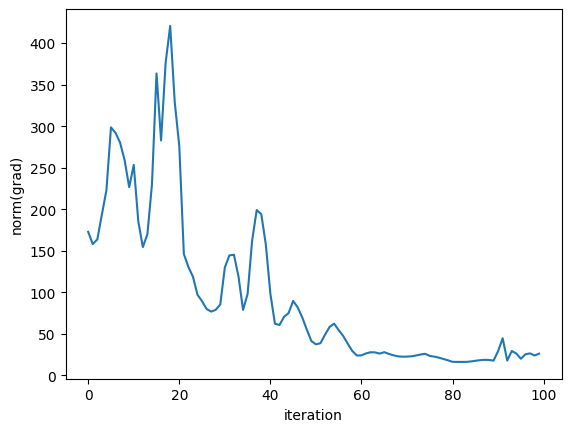

In [23]:
plt.plot([np.linalg.norm(grad) for grad in history_dict['gradients']])
plt.ylabel('norm(grad)')
plt.xlabel('iteration')

Makes a nice animation of the design parameters and gradient evolution during the optimization

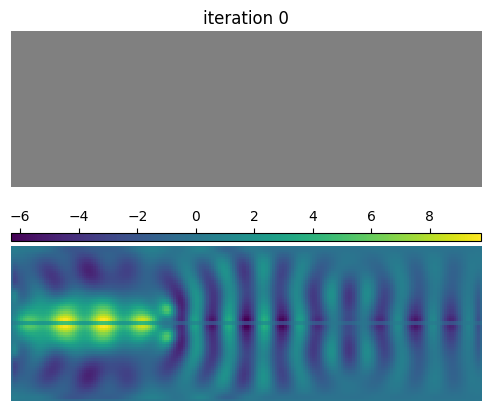

In [24]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(nrows=2, ncols=1)

gradients = history_dict['gradients']
params = history_dict['params']
gradients = [unfold_params(grad).T for grad in gradients]
params = [unfold_params(init_par).T]+[unfold_params(1.0-p).T for p in params]

div = make_axes_locatable(axs[1])
div0 = make_axes_locatable(axs[0])
cax = div.append_axes('top', size='5%', pad=0.05)
cax0 = div0.append_axes('bottom', size='5%', pad=0.05)
cax0.axis('off')

def animate(i):
    im_g = axs[1].imshow(gradients[i], interpolation='none', vmin=np.min(gradients[i]), vmax=np.max(gradients[i]))
    im_p = axs[0].imshow(params[i], interpolation='none',cmap='gray', vmin=0, vmax=1)    
    axs[1].axis('off')
    axs[0].axis('off')
    cax.cla()
    fig.colorbar(im_g, cax=cax, orientation='horizontal').ax.xaxis.set_ticks_position('top')
    
    axs[0].set_title(f'iteration {i}')

anim = animation.FuncAnimation(fig, animate, frames=100, blit=False, interval=500)
anim.save('autograd_anim.mp4', fps=2.0)

Interestingly, the final quantum emitter light extractor resembles a nanocavity, even though we have considered only the coupling efficiency into the output waveguide in the optimization. We have DBR mirrors on both sides of the dipole. However, on the left side, the mirror has only a few periods and partially reflects the radiation, which couples to the output waveguide.

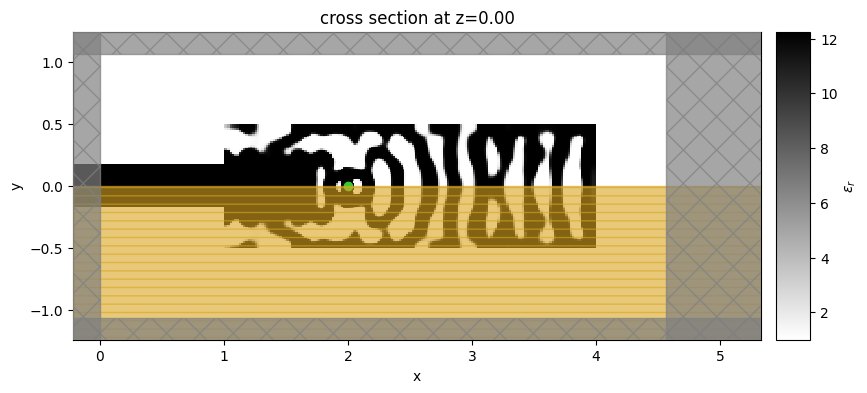

In [25]:
# here, removing substrate improved performance, but also blue-shifted cavity resonance a bit.

fig, ax = plt.subplots(1, figsize=(10, 4))
# Substrate layer.
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, -wg_thick / 2)
    ),
    medium=td.Medium(permittivity=1.0),
)
sim_final = make_adjoint_sim(params2, beta=final_beta, unfold=True)
sim_final = sim_final.updated_copy(monitors=[field_monitor_xy, mode_monitor] + field_monitor)
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax, )
plt.show()

To better understand the resultant design, let's simulate the final structure to obtain its spectral response and field distribution.

In [26]:
sim_data_final = web.run(sim_final, task_name="final QE light extractor")

07:02:44 EDT Created task 'final QE light extractor' with task_id               
             'fdve-cbc3b061-1762-4815-9b8d-63790ddb488b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=338633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cbc3b061-1762-4815-9b8d-63790ddb488b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=367993;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cbc3b061-1762-4815-9b8d-63790ddb488b\taskId]8;;\]8;id=338633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cbc3b061-1762-4815-9b8d-63790ddb488b\=]8;;\]8;id=368956;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cbc3b061-1762-4815-9b8d-63790ddb488b\fdve]8;;\]8;id=338633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cbc3b061-1762-4815-9b8d-63790ddb488b\-cbc3b061-176]8;;\
             ]8;id=338633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cbc3b061-1762-4815-9b8d-63790ddb488b\2-4815-9b8d-63790ddb488b']8;;\.

Output()

07:02:46 EDT status = success

Output()

07:02:53 EDT loading simulation from simulation_data.hdf5

In this cavity-like system, the extraction efficiency of photons from the QE into the collection waveguide mode is proportional to $\beta\times C_{wg}$, where the $\beta$-factor quantifies the fraction of the QE spontaneous emission emitted in the cavity mode, and $C_{wg}$ is the fraction of the cavity photons coupled to the guided mode `A. Enderlin, Y. Ota, R. Ohta, N. Kumagai, S. Ishida, S. Iwamoto, and Y. Arakawa, "High guided mode–cavity mode coupling for an efficient extraction of spontaneous emission of a single quantum dot embedded in a photonic crystal nanobeam cavity," Phys. Rev. B 86, 075314 (2012)` [DOI: 10.1103/PhysRevB.86.075314](https://link.aps.org/doi/10.1103/PhysRevB.86.075314). By the field distribution image below, we can see a cavity mode resonance, which should increase the Purcell factor at the QE position, thus contributing to a higher $\beta$-factor. At the same time, the partial reflection mirror at the left side was potentially optimized to adjust $C_{wg}$.

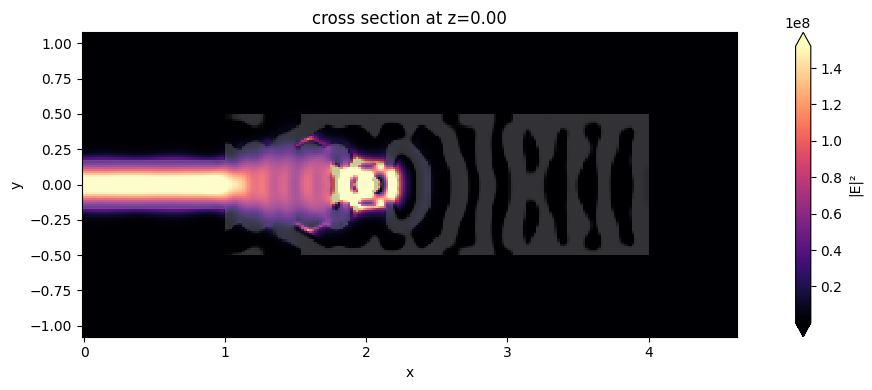

In [27]:
f, ax1 = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)
sim_data_final.plot_field("field_xy", "E", "abs^2", z=0, ax=ax1, f=freqs[0])
plt.show()

To conclude, we will calculate the final coupling efficiency and the cavity Purcell value. The coupling efficiency is above 80% along an extensive wavelength range, and we have confirmed the Purcell enhancement.

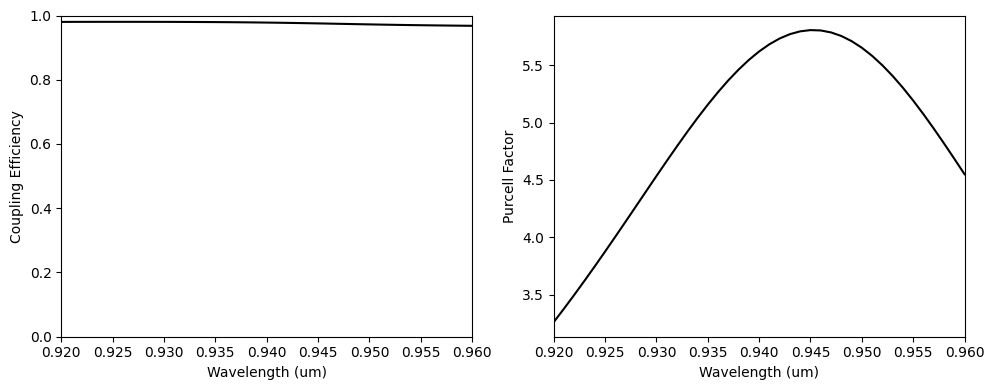

In [28]:
# Coupling efficiency.
mode_amps = sim_data_final["mode_monitor"].amps.sel(direction="-", mode_index=0)
mode_power = np.abs(mode_amps) ** 2
dip_power = np.zeros(n_wl)
for i in range(len(field_monitor)):
    field_mon = sim_data_final[f"field_monitor_{i}"]
    dip_power += np.abs(field_mon.flux)
coup_eff = mode_power / dip_power

# Purcell factor.
bulk_power = ((2 * np.pi * freqs) ** 2 / (12 * np.pi)) * (td.MU_0 * n_wg / td.C_0)
bulk_power = bulk_power * 2 ** (2 * np.sum(np.abs(sim_final.symmetry)))
purcell = dip_power / bulk_power

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_ylim(0, 1)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
ax2.plot(wl_range, purcell, "-k")
ax2.set_xlabel("Wavelength (um)")
ax2.set_ylabel("Purcell Factor")
ax2.set_xlim(wl - bw / 2, wl + bw / 2)
plt.show()

In [29]:
print(np.max(coup_eff.values))
print(np.min(coup_eff.values))

0.9802964058962308
0.96789310055428


## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry, a `frequency` to evaluate the permittivity, and a `permittivity_threshold` to define the shape boundaries in custom mediums. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

In [30]:
# make the misc/ directory to store the GDS file if it doesnt exist already
import os
if not os.path.exists('./misc/'):
    os.mkdir('./misc/')

sim_final.to_gds_file(
    fname="./misc/inv_des_light_extractor_autograd.gds",
    z=0,
    permittivity_threshold=(eps_max + eps_min) / 2,
    frequency=freq,
)